# 결정 트리

## 결정 트리를 사용한 첫번째 모델

In [7]:
# 판다스와 넘파이를 임포트합니다.
import pandas as pd
import numpy as np

# # 경고를 끕니다.
# import warnings
# warnings.filterwarnings('ignore')
%config InlineBackend.figure_formats = ['svg']

In [8]:
CENSUS_DATA = '../dataset/xgboost/census_cleaned.csv'
df_census = pd.read_csv(CENSUS_DATA)

# 데이터를 X와 y로 나눕니다.
X = df_census.iloc[:,:-1]
y = df_census.iloc[:,-1]

# train_test_split 함수를 임포트합니다.
from sklearn.model_selection import train_test_split

# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# DecisionTreeClassifier를 임포트합니다.
from sklearn.tree import DecisionTreeClassifier

# accuracy_score를 임포트합니다.
from sklearn.metrics import accuracy_score

# 분류 모델을 만듭니다.
clf = DecisionTreeClassifier(random_state=2)

# 훈련 데이터로 모델을 훈련합니다.
clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측을 만듭니다.
y_pred = clf.predict(X_test)

# 정확도를 계산합니다.
accuracy_score(y_pred, y_test)

clf.score(X_test, y_test)

0.8131679154894976

## 결정 트리는 어떻게 작동하는가?

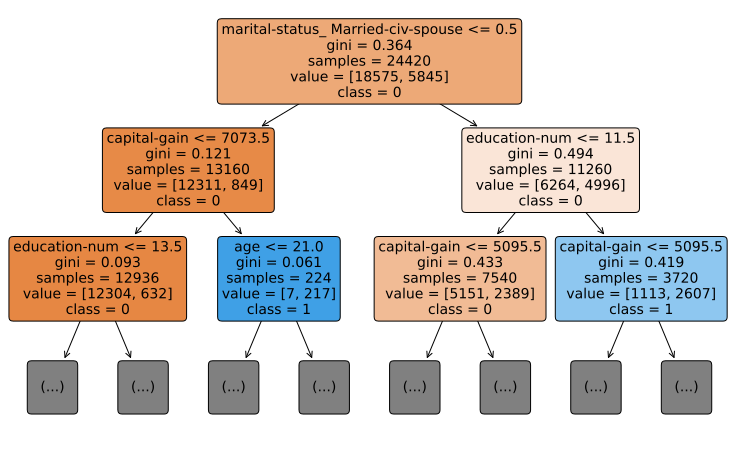

In [10]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(13,8))
plot_tree(clf, max_depth=2, feature_names=list(X.columns), class_names=['0', '1'], filled=True, rounded=True, fontsize=14)
plt.show()

## 결정 트리 하이퍼파라미터 튜닝

In [12]:
BIKES_DATA = '../dataset/xgboost/bike_rentals_cleaned.csv'

# bike_rentals_cleaned 데이터셋을 로드합니다.
df_bikes = pd.read_csv(BIKES_DATA)

# 데이터를 X와 y로 나눕니다.
X_bikes = df_bikes.iloc[:,:-1]
y_bikes = df_bikes.iloc[:,-1]

# LinearRegression을 임포트합니다.
from sklearn.linear_model import LinearRegression

# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X_bikes, y_bikes, random_state=2)

# DecisionTreeRegressor를 임포트합니다.
from sklearn.tree import DecisionTreeRegressor

# cross_val_score를 임포트합니다.
from sklearn.model_selection import cross_val_score

# DecisionTreeRegressor 객체를 만듭니다.
reg = DecisionTreeRegressor(random_state=2)

# 평균 제곱 오차로 교차 검증 점수를 계산합니다.
scores = cross_val_score(reg, X_bikes, y_bikes, scoring='neg_mean_squared_error', cv=5)

# 제곱근을 계산합니다.
rmse = np.sqrt(-scores)

# 평균을 출력합니다.
print('RMSE 평균: %0.2f' % (rmse.mean()))

RMSE 평균: 1233.36


## 과적합일까?

In [14]:
# DecisionTreeRegressor를 훈련 세트에서 훈련하고 점수를 계산합니다.
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_train)
from sklearn.metrics import mean_squared_error
reg_mse = mean_squared_error(y_train, y_pred)
reg_rmse = np.sqrt(reg_mse)
reg_rmse

0.0

In [15]:
leaf_node_count = 0
tree = reg.tree_
for i in range(tree.node_count):
    if (tree.children_left[i] == -1) and (tree.children_right[i] == -1):
        leaf_node_count += 1
        if tree.n_node_samples[i] > 1:
            print('노드 인덱스:', i, ', 샘플 개수:', tree.n_node_samples[i])
print('전체 리프 노드 개수:', leaf_node_count)

노드 인덱스: 123 , 샘플 개수: 2
전체 리프 노드 개수: 547


## GridSearchCV

In [20]:
# GridSearchCV를 임포트합니다.
from sklearn.model_selection import GridSearchCV

# max_depth 매개변수를 선택합니다.
params = {'max_depth':[None,2,3,4,6,8,10,20]}

# 회귀 모델을 만듭니다.
reg = DecisionTreeRegressor(random_state=2)

# GridSearchCV 객체를 초기화합니다.
grid_reg = GridSearchCV(reg, params, scoring='neg_mean_squared_error', 
                        cv=5, return_train_score=True, n_jobs=-1)

# X_train와 y_train로 그리드 서치를 수행합니다.
grid_reg.fit(X_train, y_train)

# 최상의 매개변수를 추출합니다.
best_params = grid_reg.best_params_

# 최상의 매개변수를 출력합니다.
print("최상의 매개변수:", best_params)

# 최상의 점수를 계산합니다.
best_score = np.sqrt(-grid_reg.best_score_)

# 최상의 점수를 출력합니다.
print("훈련 점수: {:.3f}".format(best_score))

최상의 매개변수: {'max_depth': 6}
훈련 점수: 951.398


In [22]:
# 최상의 모델을 추출합니다.
best_model = grid_reg.best_estimator_

# 테스트 세트에서 예측을 만듭니다.
y_pred = best_model.predict(X_test)

# mean_squared_error를 임포트합니다.
from sklearn.metrics import mean_squared_error

# 테스트 세트의 제곱근 오차를 계산합니다.
rmse_test = mean_squared_error(y_test, y_pred)**0.5

# 테스트 세트 점수를 출력합니다.
print('테스트 점수: {:.3f}'.format(rmse_test))

테스트 점수: 864.670


### min_samples_leaf

In [23]:
# grid_search 함수를 만듭니다.
def grid_search(params, reg=DecisionTreeRegressor(random_state=2)):
    grid_reg = GridSearchCV(reg, params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    grid_reg.fit(X_train, y_train)
    best_params = grid_reg.best_params_
    print("최상의 매개변수:", best_params)
    best_score = np.sqrt(-grid_reg.best_score_)
    print("훈련 점수: {:.3f}".format(best_score))
    y_pred = grid_reg.predict(X_test)
    rmse_test = mean_squared_error(y_test, y_pred)**0.5
    print('테스트 점수: {:.3f}'.format(rmse_test))

In [24]:
X_train.shape

(548, 12)

In [25]:
grid_search(params={'min_samples_leaf':[1,2,4,6,8,10,20,30]})

최상의 매개변수: {'min_samples_leaf': 8}
훈련 점수: 896.083
테스트 점수: 855.620


In [26]:
grid_search(params={'max_depth':[None,2,3,4,6,8,10,20],'min_samples_leaf':[1,2,4,6,8,10,20,30]})

최상의 매개변수: {'max_depth': 6, 'min_samples_leaf': 2}
훈련 점수: 870.396
테스트 점수: 913.000


In [23]:
grid_search(params={'max_depth':[6,7,8,9,10],'min_samples_leaf':[3,5,7,9]})

최상의 매개변수: {'max_depth': 9, 'min_samples_leaf': 7}
훈련 점수: 888.905
테스트 점수: 878.538


## 사례 연구 - 심장 질환

In [31]:
HEART_DATA = '../dataset/xgboost/heart_disease.csv'
# heart_disease.csv를 데이터프레임으로 로드합니다.
df_heart = pd.read_csv(HEART_DATA)

# 처음 다섯 개 행을 출력합니다.
df_heart.head()

# 데이터를 X와 y로 나눕니.
X = df_heart.iloc[:,:-1]
y = df_heart.iloc[:,-1]

# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# DecisionTreeClassifier 객체를 만듭니다.
model = DecisionTreeClassifier(random_state=2)

# 교차 검증 점수를 계산합니다.
scores = cross_val_score(model, X, y, cv=5)

# 정확도를 출력합니다.
print('정확도:', np.round(scores, 2))

# 평균 정확도를 출력합니다.
print('정확도 평균: %0.2f' % (scores.mean()))

정확도: [0.74 0.85 0.77 0.73 0.7 ]
정확도 평균: 0.76


### RandomizedSearchCV

In [32]:
# RandomizedSearchCV를 임포트합니다.
from sklearn.model_selection import RandomizedSearchCV

def randomized_search_clf(params, runs=20, clf=DecisionTreeClassifier(random_state=2)):
    rand_clf = RandomizedSearchCV(clf, params, n_iter=runs, cv=5, n_jobs=-1, random_state=2)
    rand_clf.fit(X_train, y_train)
    best_model = rand_clf.best_estimator_
    best_score = rand_clf.best_score_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return best_model

### 하이퍼파라미터 선택

In [33]:
randomized_search_clf(
    params={
        'criterion':['entropy', 'gini'],
        'splitter':['random', 'best'],
        'min_samples_split':[2, 3, 4, 5, 6, 8, 10],
        'min_samples_leaf':[1, 0.01, 0.02, 0.03, 0.04],
        'min_impurity_decrease':[0.0, 0.0005, 0.005, 0.05, 0.10, 0.15, 0.2],
        'max_leaf_nodes':[10, 15, 20, 25, 30, 35, 40, 45, 50, None],
        'max_features':['auto', 0.95, 0.90, 0.85, 0.80, 0.75, 0.70],
        'max_depth':[None, 2,4,6,8],
        'min_weight_fraction_leaf':[0.0, 0.0025, 0.005, 0.0075, 0.01, 0.05]
    })

DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features=0.8,
                       max_leaf_nodes=45, min_samples_leaf=0.04,
                       min_samples_split=10, min_weight_fraction_leaf=0.05,
                       random_state=2)

### 탐색 범위 좁히기

In [34]:
best_model = randomized_search_clf(
    params={'max_depth':[None, 6, 7],
            'max_features':['auto', 0.78],
            'max_leaf_nodes':[45, None],
            'min_samples_leaf':[1, 0.035, 0.04, 0.045, 0.05],
            'min_samples_split':[2, 9, 10],
            'min_weight_fraction_leaf': [0.0, 0.05, 0.06, 0.07],
            },
    runs=100)

In [35]:
# 교차 검증 점수를 계산합니다.
scores = cross_val_score(best_model, X, y, cv=5)

# 정확도를 출력합니다.
print('정확도:', np.round(scores, 2))

# 평균 정확도를 출력합니다.
print('정확도 평균: %0.2f' % (scores.mean()))

정확도: [0.82 0.9  0.8  0.8  0.78]
정확도 평균: 0.82


### `loguniform`을 사용한 랜덤 서치

In [41]:
from sklearn.utils.fixes import loguniform
from scipy.stats import randint

params = {'max_depth': randint(1,100),
          'max_leaf_nodes': randint(2,100),
          'max_features': loguniform(1e-5,1),
          'min_samples_split': loguniform(1e-5,0.5),
          'min_samples_leaf': loguniform(1e-5,0.5),
          'min_impurity_decrease': loguniform(1e-5,1),
          'min_weight_fraction_leaf': loguniform(1e-5,0.5)}

dtc = DecisionTreeClassifier(random_state=0)
rs = RandomizedSearchCV(dtc, params, n_iter=100, n_jobs=-1, random_state=0)
rs.fit(X_train, y_train)

print('최상의 교차 검증 점수:', rs.best_score_)
print('최상의 매개변수:', rs.best_params_)

최상의 교차 검증 점수: 0.7580676328502415
최상의 매개변수: {'max_depth': 48, 'max_features': 0.43091880545542754, 'max_leaf_nodes': 69, 'min_impurity_decrease': 0.0013196080073784372, 'min_samples_leaf': 0.004040744352999553, 'min_samples_split': 0.00022327828197850555, 'min_weight_fraction_leaf': 0.020901302492784418}


### 특성 중요도

In [42]:
best_model.fit(X, y)

DecisionTreeClassifier(max_depth=7, max_features=0.78, max_leaf_nodes=45,
                       min_samples_leaf=0.045, min_samples_split=9,
                       min_weight_fraction_leaf=0.06, random_state=2)

In [43]:
best_model.feature_importances_

array([0.04826754, 0.04081653, 0.48409586, 0.00568635, 0.        ,
       0.        , 0.        , 0.00859483, 0.        , 0.02690379,
       0.        , 0.18069065, 0.20494446])

In [44]:
# 열과 feature_importances_를 딕셔너리로 묶습니다.
feature_dict = dict(zip(X.columns, best_model.feature_importances_))

# operator를 임포트합니다.
import operator

# 튜플에 있는 값을 기준으로 딕셔너리를 정렬합니다.
sorted(feature_dict.items(), key=operator.itemgetter(1), reverse=True)[0:3]

[('cp', 0.4840958610240171),
 ('thal', 0.20494445570568706),
 ('ca', 0.18069065321397942)]

In [45]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_model, X, y, n_jobs=-1, random_state=0)

feature_dict = dict(zip(X.columns, result.importances_mean))
sorted(feature_dict.items(), key=operator.itemgetter(1), reverse=True)[0:3]

[('cp', 0.08976897689768981),
 ('thal', 0.08382838283828387),
 ('ca', 0.05940594059405944)]